# <font color = 'magenta'> Introduction
* user enters a tv series and generates a heatmap of the ratings per episode per season
* user votes are generated as well per episode per season
* a barchart will breakdown the ratings on the scale of 1-10

In [2]:
%%time
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=2.0)
sns.set_palette("magma")
import pylab
pylab.rcParams['figure.figsize'] = (20, 20)
plt.style.use('dark_background')

import os
db_user = os.environ.get('DB_USER_imdb')
db_pw = os.environ.get('DB_PASSWORD_imdb')


import mysql.connector
import warnings
warnings.filterwarnings('ignore')

connection = mysql.connector.connect(host="localhost", user=db_user,passwd=db_pw,database="imdb100")

connection

Wall time: 1.85 s


# <font color = 'fggd'> Data Cleaning

In [3]:
%%time
#find tconst for tv title, e.g. "Game of Thrones"
# default is "Game of Thrones"
# user1="Game of Thrones"
# example1="how i met your mother"
# example1="game of thrones"
# example1="breaking bad"
# example1="mad men"
example1 = "devs"
#######APOSTROPHE TEST #############
####################################
# example1="The Handmaid's Tale"
# example1="Tom Clancy's Jack Ryan"
# Results: Passed!
###################################

# Certain shows, e.g. DEVS (2020) must specify tvMiniSeries; imDB criteria <2 seasons
# Certain shows, e.g. Queen's Gambit (2020) must specify tvMiniSeries; imDB criteria <2 seasons


user1=f"""SELECT * FROM title_basics WHERE primaryTitle LIKE "{example1}" and titleType = 'tvMiniSeries';"""



# user1="SELECT * FROM title_basics WHERE primaryTitle LIKE '"+input("What Title? ")+"' and titleType = 'tvSeries';"
tconst = pd.read_sql_query(user1,connection)

Wall time: 11 s


In [4]:
series_id=tconst['tconst'][0]
series_id

'tt8134186'

In [5]:
q1="SELECT a.tconst, parentTconst, seasonNumber, episodeNumber, startYear,averageRating ,numVotes,primaryTitle, runtimeMinutes FROM title_episode a JOIN title_ratings b ON a.tconst = b.tconst JOIN title_basics c ON a.tconst = c.tconst WHERE parentTconst = '"+series_id+"'" 
q2 = "SELECT a.tconst,a.primaryTitle, b.averageRating, b.numVotes FROM title_basics a JOIN title_ratings b ON a.tconst = b.tconst WHERE a.tconst = '"+series_id+"';"

In [6]:
%%time

ga = pd.read_sql_query(q1,connection)

ga.fillna(0,inplace=True)


Wall time: 7.26 s


In [7]:
ga2 = pd.read_sql_query(q2,connection)
ga2

,tconst,primaryTitle,averageRating,numVotes
0,tt8134186,Devs,7.7,35375


In [8]:
title = ga2['primaryTitle'][0]

In [9]:
ga['runtimeMinutes']=ga['runtimeMinutes'].astype('int')
ga['startYear']=ga['startYear'].astype('int64')

In [10]:
df = ga.copy()

df1=df[['seasonNumber', 'episodeNumber','averageRating']].copy()

p1=df1.pivot('episodeNumber','seasonNumber')
# p1

Wall time: 283 ms


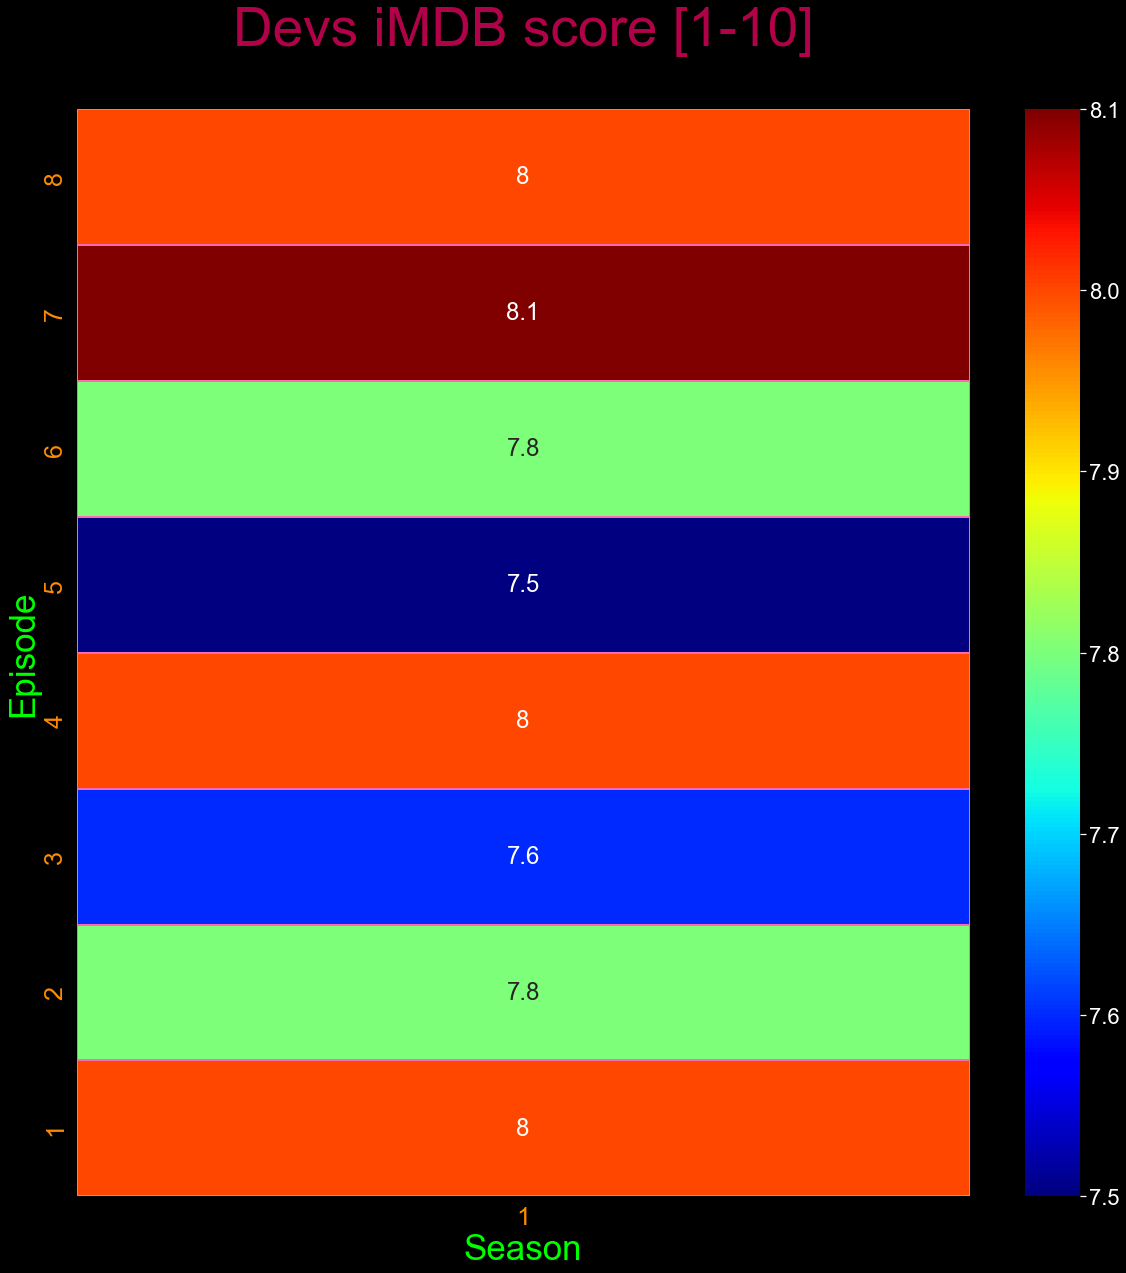

In [11]:
%%time
# g.set_xlabel('Year',size=34,color='lime')
# g.set_ylabel('Hours',size=34,color='lime')
# fig = plt.figure(figsize=(30,30))
ax=sns.heatmap(p1,cmap='jet',linewidths=0.25,annot=True,linecolor='hotpink')
ax.set_title(f"{title} iMDB score [1-10]\n",color='#b00149',size=55)
ax.set_xlabel('Season',size=35,color='lime')
ax.set_ylabel('Episode',size=35,color='lime')
ax.invert_yaxis()
xticks = list(range(1,len(p1.columns)+1,1))
# list1
plt.xticks(np.arange(len(xticks))+0.5,xticks,rotation=0,color='darkorange',size=25)
plt.yticks(color='darkorange',size=25)

plt.savefig(f'{title} heatmap ratings.png')

# Votes

Wall time: 212 ms


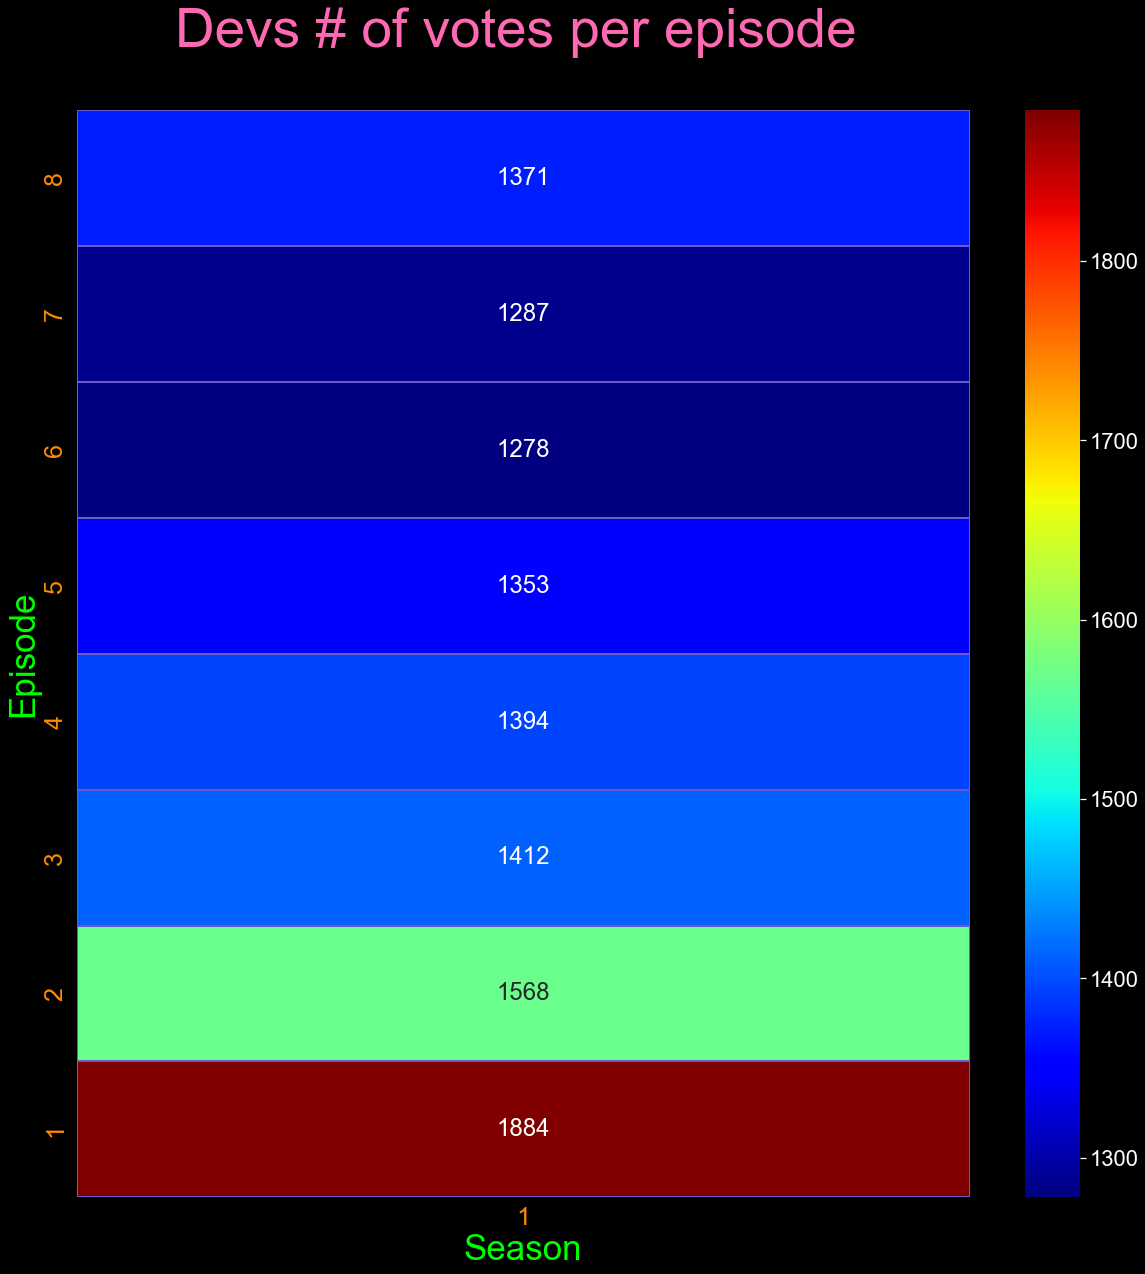

In [12]:
%%time
df2 = ga.copy()

df2=df2[['seasonNumber', 'episodeNumber','numVotes']].copy()

p2=df2.pivot('episodeNumber','seasonNumber')
p2

# g.set_xlabel('Year',size=34,color='lime')
# g.set_ylabel('Hours',size=34,color='lime')

ax=sns.heatmap(p2,cmap='jet',linewidths=0.25,annot=True,fmt='g', linecolor='slateblue')

ax.set_title(f"{title} # of votes per episode \n",color='hotpink',size=55)
ax.set_xlabel('Season',size=35,color='lime')
ax.set_ylabel('Episode',size=35,color='lime')
ax.invert_yaxis()
xticks = list(range(1,len(p1.columns)+1,1))
# list1
plt.xticks(np.arange(len(xticks))+0.5,xticks,rotation=0,color='darkorange',size=25)
plt.yticks(color='darkorange',size=25)

plt.savefig(f'{title} heatmap votes.png')

In [13]:
###########################################
p2 = p1.copy()

In [14]:
breakdown = []


p2=p2.fillna(0)
for x, y in p2.iterrows():
    for z in y:
        breakdown.append(int(z))

if 0 in breakdown: 
    breakdown.remove(0)

dict99 = {"breakdown":breakdown}
breakdown2=pd.DataFrame(dict99)
results=breakdown2.value_counts()

if 0 in breakdown:
    results=results.drop(0)

results=results.sort_index()
index2=[]
for x in results.index:
    index2.append(x[0])

Wall time: 191 ms


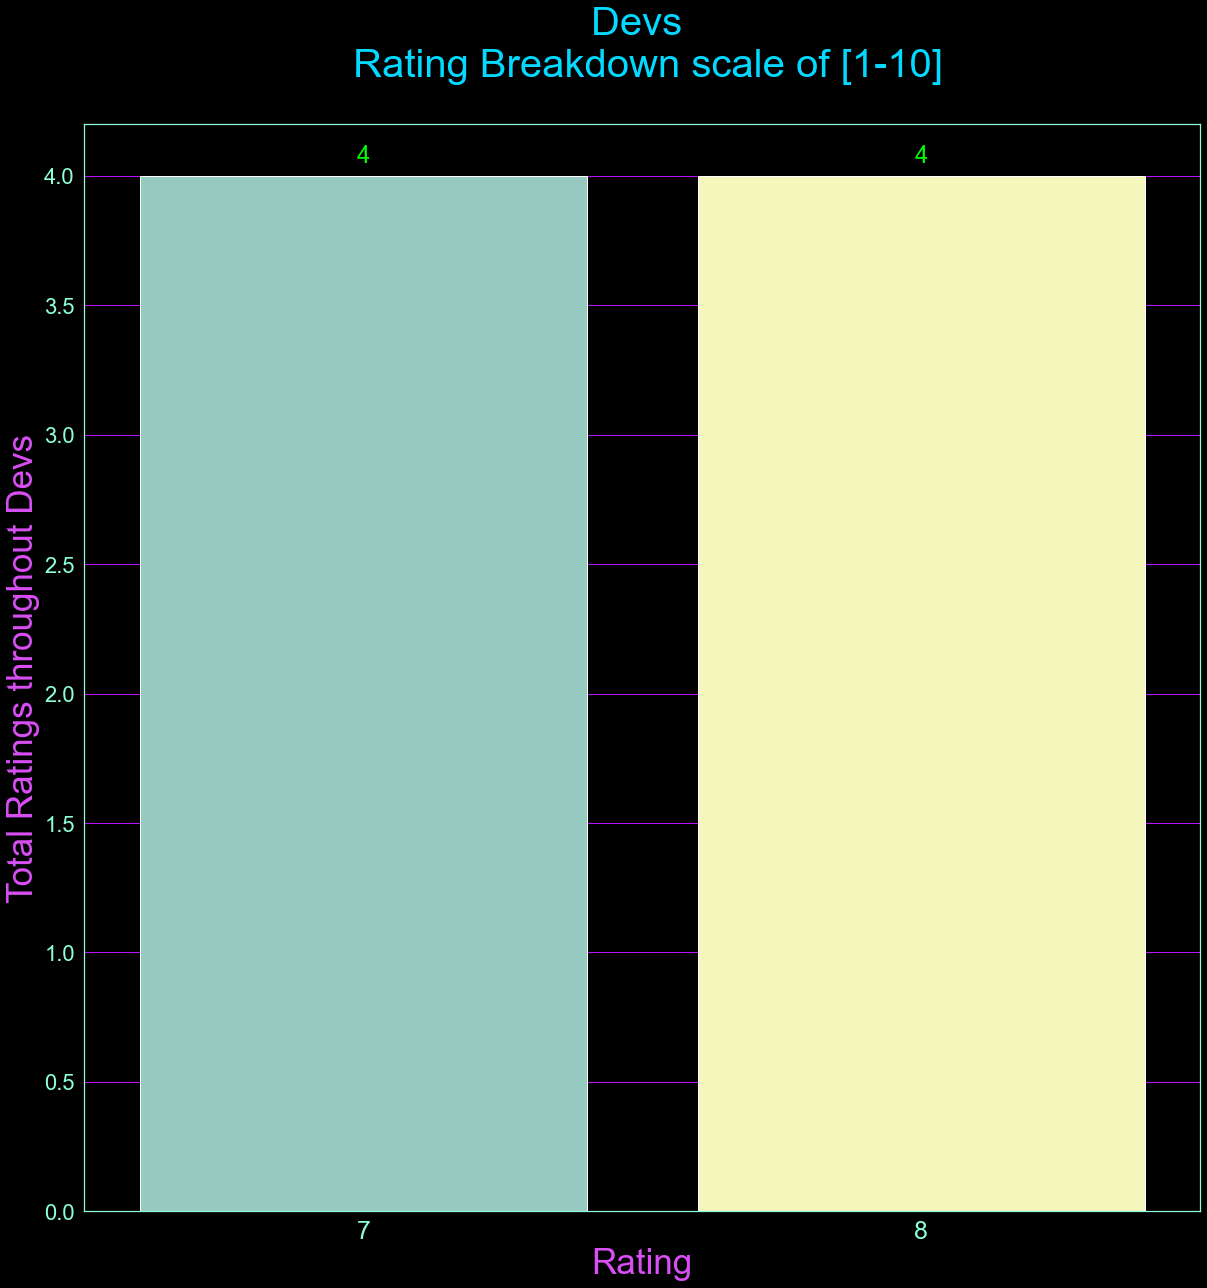

In [15]:
%%time
ax0=sns.barplot(x=index2,y=results)

plt.xticks(np.arange(len(index2)),index2,rotation=0,size=25)

ax0.set_xlabel("Rating",size=35,color="#d94ff5")
ax0.set_ylabel(f"Total Ratings throughout {title}",size=35,color="#d94ff5")
ax0.set_title(f"{title} \n Rating Breakdown scale of [1-10]\n",size=40,color="#04d9ff")

ax0.grid(axis="y",which="both",color='#bc13fe')
# ax0.grid(axis='y',color='#bc13fe')

ax0.spines['bottom'].set_color('#8cffdb')
ax0.spines['right'].set_color('#8cffdb')
ax0.spines['top'].set_color('#8cffdb')#fd4659
ax0.tick_params(axis='x', colors='#8cffdb')
ax0.spines['left'].set_color('#8cffdb')
ax0.tick_params(axis='y', colors='#8cffdb')


for p in ax0.patches:
    ax0.annotate(format(p.get_height(), '.0f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 20), 
                   textcoords = 'offset points',color='lime')
    
plt.savefig(f'{title} barchart rating breakdown.png')

In [16]:
df1.head()

,seasonNumber,episodeNumber,averageRating
0,1,1,8.0
1,1,2,7.8
2,1,3,7.6
3,1,4,8.0
4,1,5,7.5


In [17]:
df1_season = df1.groupby("seasonNumber").agg(['mean','var'])
df1_season

episodeNumber      averageRating          
                      mean  var          mean       var
seasonNumber                                           
1                      4.5  6.0          7.85  0.045714

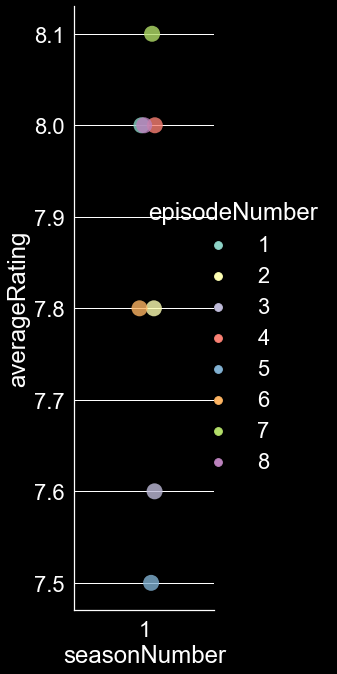

In [34]:
g = sns.catplot(data=df1, x='seasonNumber', y='averageRating',hue='episodeNumber',legend=True,s=16,alpha=0.8)
g.fig.set_size_inches(5,12)

<AxesSubplot:xlabel='seasonNumber', ylabel='averageRating'>

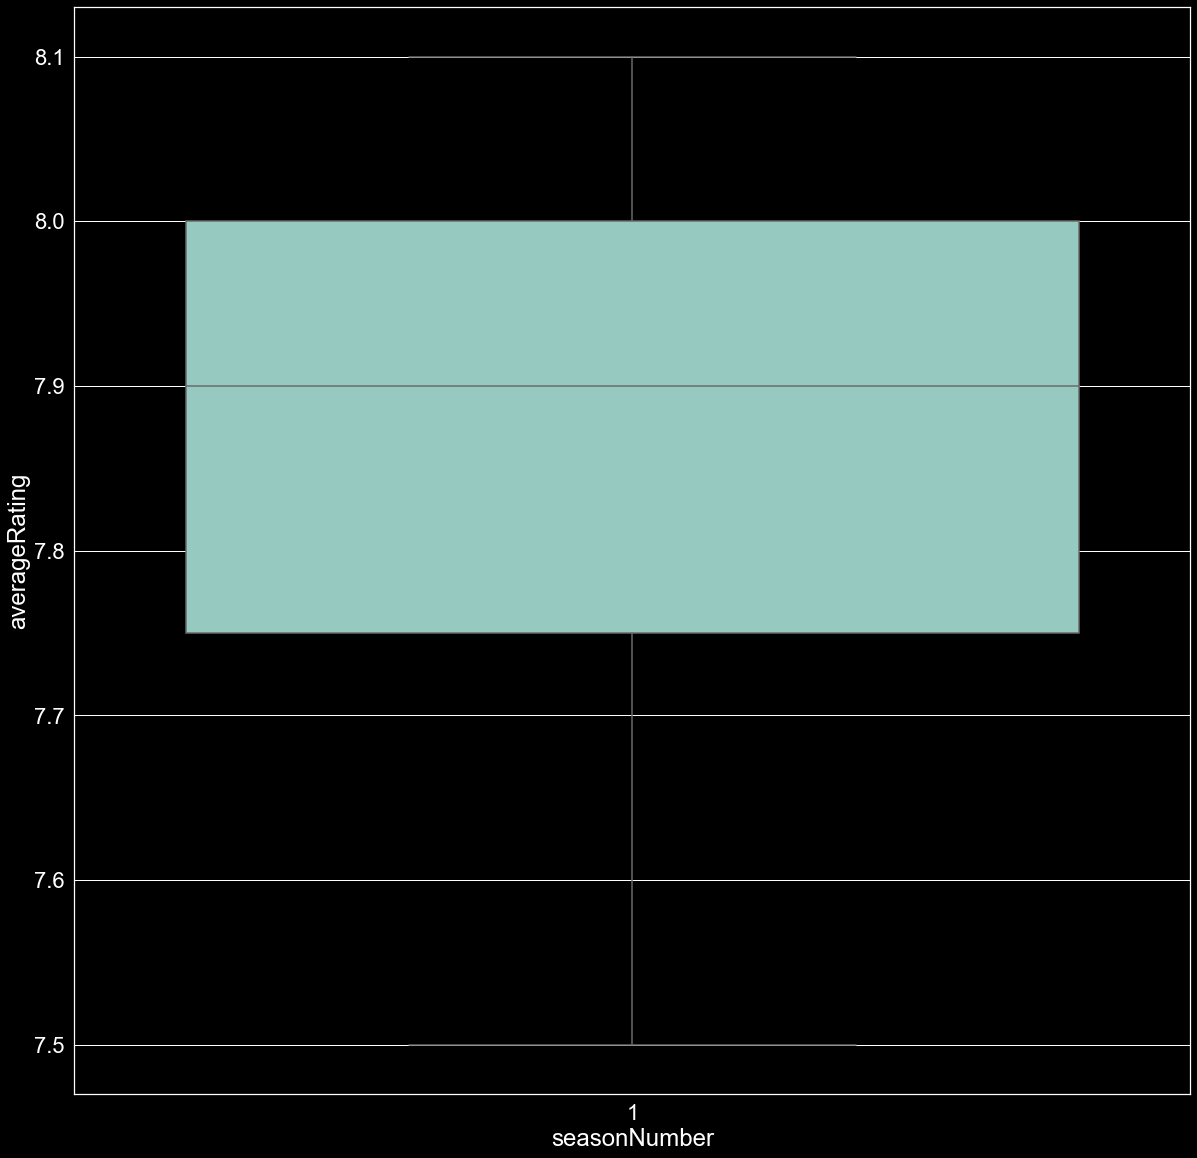

In [29]:
# plt.figure(figsize=(20,20))
sns.boxplot(data=df1, x='seasonNumber', y='averageRating')

Text(0.5, 1.0, 'Devs \n Rating Distribution by season\n')

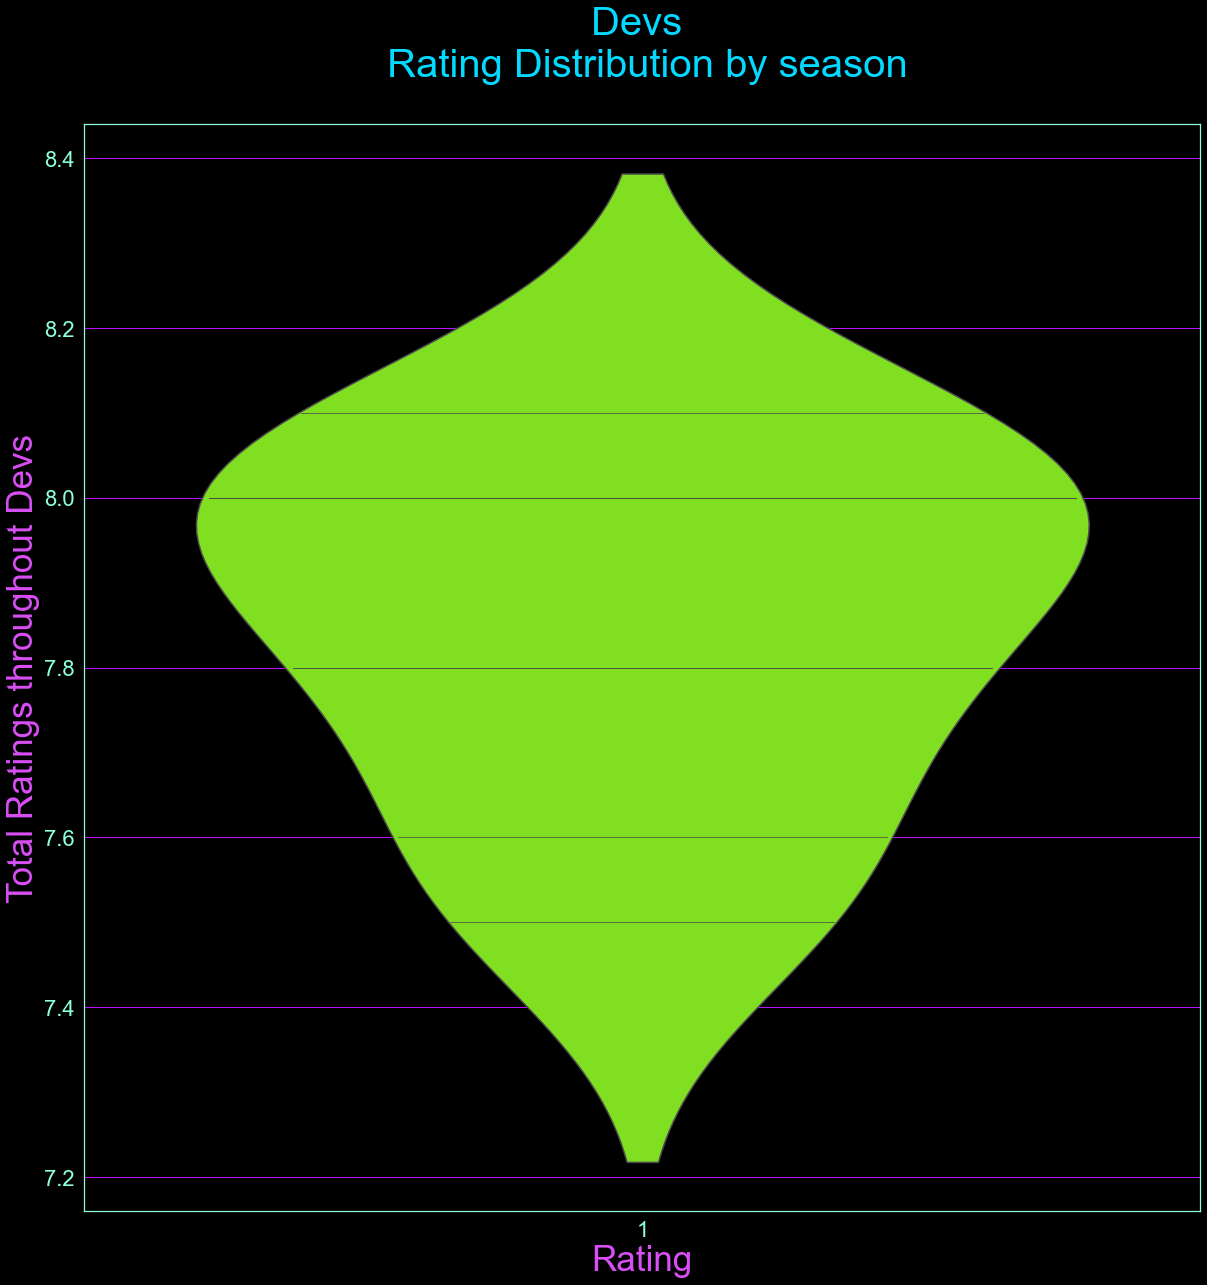

In [26]:
ax0=sns.violinplot(data=df1, x='seasonNumber', y='averageRating',inner="stick",color = 'chartreuse')


ax0.set_xlabel("Rating",size=35,color="#d94ff5")
ax0.set_ylabel(f"Total Ratings throughout {title}",size=35,color="#d94ff5")

ax0.grid(axis="y",which="both",color='#bc13fe')
# ax0.grid(axis='y',color='#bc13fe')

ax0.spines['bottom'].set_color('#8cffdb')
ax0.spines['right'].set_color('#8cffdb')
ax0.spines['top'].set_color('#8cffdb')#fd4659
ax0.tick_params(axis='x', colors='#8cffdb')
ax0.spines['left'].set_color('#8cffdb')
ax0.tick_params(axis='y', colors='#8cffdb')
ax0.set_title(f"{title} \n Rating Distribution by season\n",size=40,color="#04d9ff")
